<center><b>EE 538 Spring 2021<br>
Low-Noise Analog Circuit Design<br>
University of Washington Electrical & Computer Engineering</b></center>


<b>Instructor: Jason Silver<br>
Assignment #4 (10 points)<br>
Due Sunday, May 2 (Submit on Canvas as a Jupyter Notebook)</b> 

*Please show your work*

In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

In [2]:
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

<b>Problem 1: Common-source JFET amplifier

<img src="img/CS_JFET.png" width=300 />

<br>
<center><b>Figure 1. Common-source amplifier </center>

The drain current of an $n$-channel JFET can be described as a function of $V_{gs}$ by

\begin{equation}
I_d = \beta(V_{gs} - V_{th})^2
\end{equation}

where $\beta = I_{DSS}/V_{th}^2$ (unrelated to the current gain parameter for BJTs). $I_{DSS}$ represents the maximum drain current that is reached when $V_{gs} = 0$. Using this expression, the transconductance can be expressed as

\begin{equation}
g_m = 2\cdot\sqrt{\beta I_D}
\end{equation}


For the following, use $\beta = 24 mA/V^2$ and $V_{gs} - V_{th} = 0.29V$

<u>*Analysis*</u>

__a)__ Assuming $I_{D} = 2mA$, $I_G = 2pA$, and $R_D = 4k\Omega$, determine noise density values for $i_n$ and $e_n$ of the common-source amplifier in Figure 1, ignoring $1/f$ noise.

<img src="img/FET_noise_model.png" width=700 />

Given 


$\begin{eqnarray}
&& \gamma &=& \frac{2}{3} \\[0.5em]
&& g_m &=& 2\cdot\sqrt{\beta I_D} \\[0.5em]
&& &=& 2\cdot\sqrt{(24\cdot10^{-3}) \cdot (2\cdot10^{-3})} = 0.0139 \\[0.5em]
&& V_{gs} - V_{th} &=& V_{ov} = 0.29V \\[0.5em]
\end{eqnarray}$

<hr>

Current Noise Density

$\begin{eqnarray}
&& i_{n}^2 &=& n_{thermal}^2 + n_{shot}^2 \\[0.5em]
&&  &=& 4kT \gamma g_{m} + 2qI_G \\[0.5em]
&&  &=& (2kT \gamma g_{m} \cdot V_{ov}) + 2qI_G \\[0.5em]
&& i_{n} &=& \sqrt{(2kT \cdot (2/3)\cdot (0.0139) \cdot (0.29)) + 2q \cdot (2 \cdot 10^{-12})} \\
&& &=& 4.72 \text{ nA}/\sqrt{Hz}  \\[0.5em]
\end{eqnarray}$

<br>
Voltage Noise Density

$\begin{eqnarray}
&& e_{n}^2 && &=& \frac{i_{nd}^2 }{g_{m}^2} \\[0.5em]
&&  && &=& \frac{4kT \gamma }{g_{m}} \\[0.5em]
\end{eqnarray}$

<hr>

__b)__ The $1/f$ drain current noise of a JFET can be expressed as

\begin{equation}
i_{nf}^2 = \dfrac{K_f\cdot I_D}{f}
\end{equation}

If $f_c$ is defined as the frequency at which the thermal and flicker noise densities are equal, determine $f_c$ if $K_f = 0.0021 fA$. 

$\begin{eqnarray}
& i_{nf}^2 & &=& n_{thermal}^2 \\[0.5em]
& \dfrac{K_f\cdot I_D}{f} & &=& 4kT \gamma g_{m} \\[0.5em]
& \frac{(0.0021 \cdot 10^{-15}) \cdot (2\cdot 10^{-3})}{f_c} & &=& 4kT \cdot (2/3) \cdot (0.0139) \\[0.5em]
& f_c & &=& 27.6 \text{Hz} \\[0.5em]
\end{eqnarray}$

<hr>

__c)__ Assuming $R_s$ = $100k\Omega$, what are the signal gain and noise figure of the amplifier at $100Hz$?

$\begin{eqnarray}
&& A_v &=& -g_m (r_0 \parallel R_D) \\[0.5em]
&&  &=& -g_m R_D \\[0.5em] 
&&  &=& -(0.0139) \cdot 4000 \\[0.5em] 
&& &=& 55.6 \text{ V/V}
\end{eqnarray}$

$\begin{eqnarray}
&& NF &=& 1 + \frac{e_n^2 + i_n^2 R_S^2}{4kTR_S} \\[0.5em]
\end{eqnarray}$

In [12]:
k = 1.38e-23
T = 300
q = 1.602e-19

en_sq = 4*k*T*(V_T/(2*I_C) + r_b)
in_sq = 2*q*I_C/beta_0

NF_MOS = 10*np.log10((en_MOS_2 + 4*k*T*Rs)/(4*k*T*Rs))

NameError: name 'en_MOS_2' is not defined

In [11]:
R_s,r_b,beta_0,I_C = sp.symbols('R_s,r_b,beta_0,I_C')
k = 1.38e-23
T = 300
q = 1.602e-19
V_T = k*T/q

I_Cs = np.linspace(100*1e-6,1.5*1e-3, num=100)

en_sq = 4*k*T*(V_T/(2*I_C) + r_b)
in_sq = 2*q*I_C/beta_0
NF = 1 + (en_sq + in_sq*R_s**2)/(4*k*T*R_s)

components = {
    R_s : 1000,
    r_b : 2,
    beta_0 : 250,
}
H = sp.Matrix([NF])
H = H.subs(components)
H = lambdify(I_C,H,modules='numpy')
H = H(I_Cs)
H = H[0][0]

<u>*Verification*</u>

<hr>

__d)__ Verify your answers to a-c in Ltspice using the SPICE model of the LSK389 JFET transistor from Linear Systems. Set the DC value of $V_s$ to $-0.1V$. 

What happens to the noise figure if the temperature rises to $150C$? (this part only needs to be verified in SPICE, no calculation)

<img src="img/HW04_Model.png" width=600 />

<img src="img/HW04_DC_Operating_Point.png" width=500 />

In [3]:
filepath = 'data/HW04_27C.txt'
filepath2 = 'data/HW04_150C.txt'
df = read_ltspice(filepath,'ac')
df2 = read_ltspice(filepath2,'ac')
freq = df['Freq.']
freq2 = df2['Freq.']
mag = df['Mag_V(vout)']
mag2 = df2['Mag_V(vout)']

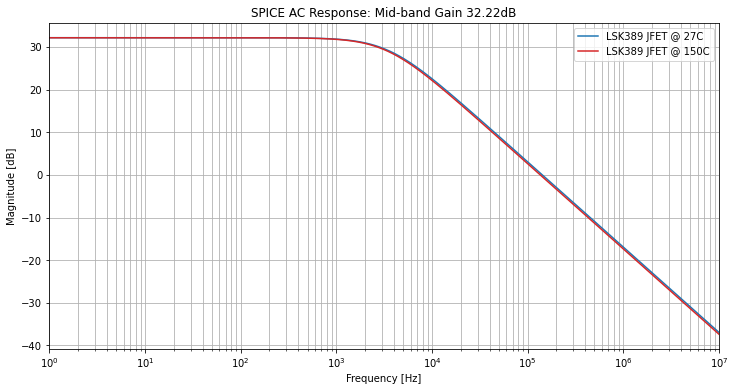

In [4]:
fig, ax = plt.subplots(1,figsize=(12,6))

ax.semilogx(freq, mag, color='tab:blue',label='LSK389 JFET @ 27C')
ax.semilogx(freq2, mag2, color='tab:red',label='LSK389 JFET @ 150C')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_title(f'SPICE AC Response: Mid-band Gain {round(max(mag),2)}dB')
ax.set_xlim(1e0,1e7)

ax.legend()
plt.show();

In [5]:
filepath = 'data/HW04_noise_27C.txt'
filepath2 = 'data/HW04_noise_150C.txt'
df = pd.read_csv(filepath)
df2 = pd.read_csv(filepath2)
freq = df['frequency']
freq2 = df2['frequency']
onoise = df['V(onoise)']
onoise2 = df2['V(onoise)']
inoise = df['V(rs)']
inoise2 = df2['V(rs)']

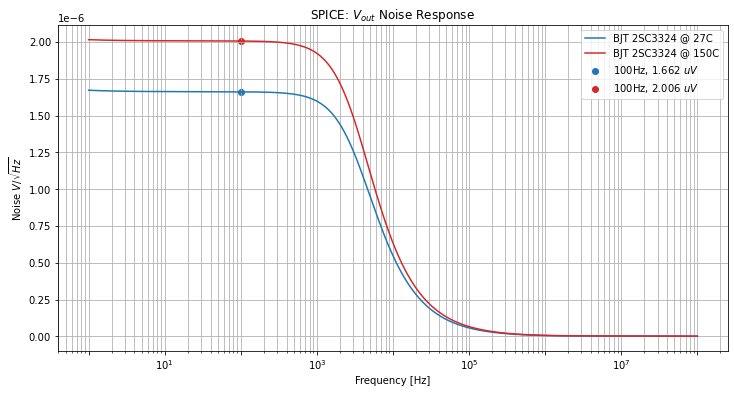

In [6]:
fig, ax = plt.subplots(1,figsize=(12,6))

x1 = np.where(freq<=100)[0][-1]
label1 = r"100Hz, {:.3f} $uV$".format(onoise[x1]*1e6)
x2 = np.where(freq2<=100)[0][-1]
label2 = r"100Hz, {:.3f} $uV$".format(onoise2[x2]*1e6)

ax.semilogx(freq, onoise, color='tab:blue',label='BJT 2SC3324 @ 27C')
ax.scatter(freq[x1],onoise[x1],label=label1,color='tab:blue')
ax.semilogx(freq2, onoise2, color='tab:red',label='BJT 2SC3324 @ 150C')
ax.scatter(freq2[x2],onoise2[x2],label=label2,color='tab:red')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise $V/\sqrt{Hz}$')
ax.set_title(r'SPICE: $V_{out}$ Noise Response')
ax.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
#ax.set_ylim(10e-9,50e-9)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.legend()
plt.show();

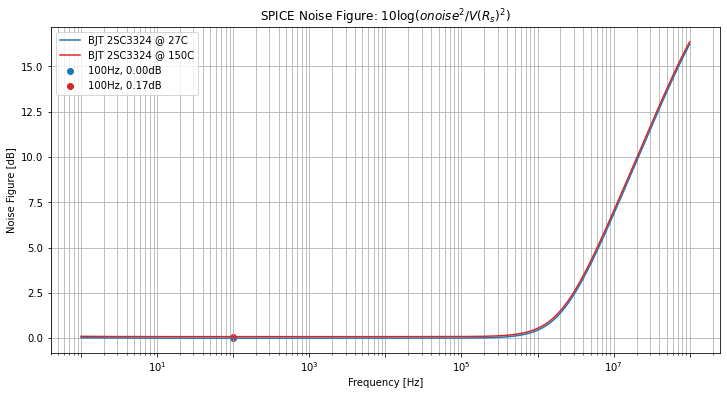

In [10]:
fig, ax = plt.subplots(1,figsize=(12,6))

x1 = np.where(freq<=100)[0][-1]
label1 = r"100Hz, {:.2f}dB".format(10*np.log10(onoise[x1]**2/inoise[x1]**2))
x2 = np.where(freq<=100)[0][-1]
label2 = r"100Hz, {:.2f}dB".format(10*np.log10(onoise2[x2]**2/inoise2[x2]**2))

ax.semilogx(freq, 10*np.log10(onoise/inoise), color='tab:blue',label='BJT 2SC3324 @ 27C')
ax.scatter(freq[x1],10*np.log10(onoise[x1]/inoise[x1]),label=label1,color='tab:blue')
ax.semilogx(freq2, 10*np.log10(onoise2/inoise2), color='tab:red',label='BJT 2SC3324 @ 150C')
ax.scatter(freq[x2],10*np.log10(onoise2[x2]/inoise2[x2]),label=label2,color='tab:red')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise Figure [dB]')
ax.set_title(r'SPICE Noise Figure: $10 \log(onoise^2/V(R_s)^2)$')
#ax.ticklabel_format(style='sci', axis='y', scilimits=(-9,-9))
#ax.set_ylim(10e-9,50e-9)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.legend()
plt.show();